<img src="image.jpg" width="2000" height="700">

# Dataset Feature Explanations

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('heart.csv')

# Data Overview

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumerical columns:\n{numerical_columns}")

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns:\n{categorical_columns}")


Numerical columns:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Categorical columns:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [6]:
cat_df = df.select_dtypes(include = ["object"])
cat_df.nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"\n{col}:")
        print(df[col].unique())


Sex:
['M' 'F']

ChestPainType:
['ATA' 'NAP' 'ASY' 'TA']

RestingECG:
['Normal' 'ST' 'LVH']

ExerciseAngina:
['N' 'Y']

ST_Slope:
['Up' 'Flat' 'Down']


In [8]:
for col in categorical_columns:
    print(f"Column : ",df[col].value_counts(dropna=False))
    print('-' * 30)

Column :  Sex
M    725
F    193
Name: count, dtype: int64
------------------------------
Column :  ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
------------------------------
Column :  RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
------------------------------
Column :  ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
------------------------------
Column :  ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64
------------------------------


In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [10]:
df.shape

(918, 12)

#####

# Data Cleaning 

In [11]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [12]:
missing_values = df.isnull().sum().sum()
print(f"\nTotal missing values: {missing_values}")


Total missing values: 0


In [13]:
df.duplicated().sum()

0

In [14]:
def detect_outliers_iqr(df, columns):
    for col in columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
        
        outlier_count = outliers.sum() 
        
        if outlier_count > 0:
            outlier_values = df[col][outliers].tolist() 
            print(f"'{col}': Outlier count = {outlier_count}, Outliers = {outlier_values}")
        else:
            print(f"'{col}': Outlier count = 0")

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
detect_outliers_iqr(df, numerical_columns)


'Age': Outlier count = 0
'RestingBP': Outlier count = 28, Outliers = [190, 180, 180, 180, 200, 180, 180, 180, 80, 200, 185, 200, 180, 180, 0, 178, 172, 180, 190, 174, 178, 180, 200, 192, 178, 180, 180, 172]
'Cholesterol': Outlier count = 183, Outliers = [468, 518, 412, 529, 466, 603, 491, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 458, 0, 0, 0, 0, 0, 0, 564, 417, 409]
'FastingBS': Outlier count = 214, Outliers = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

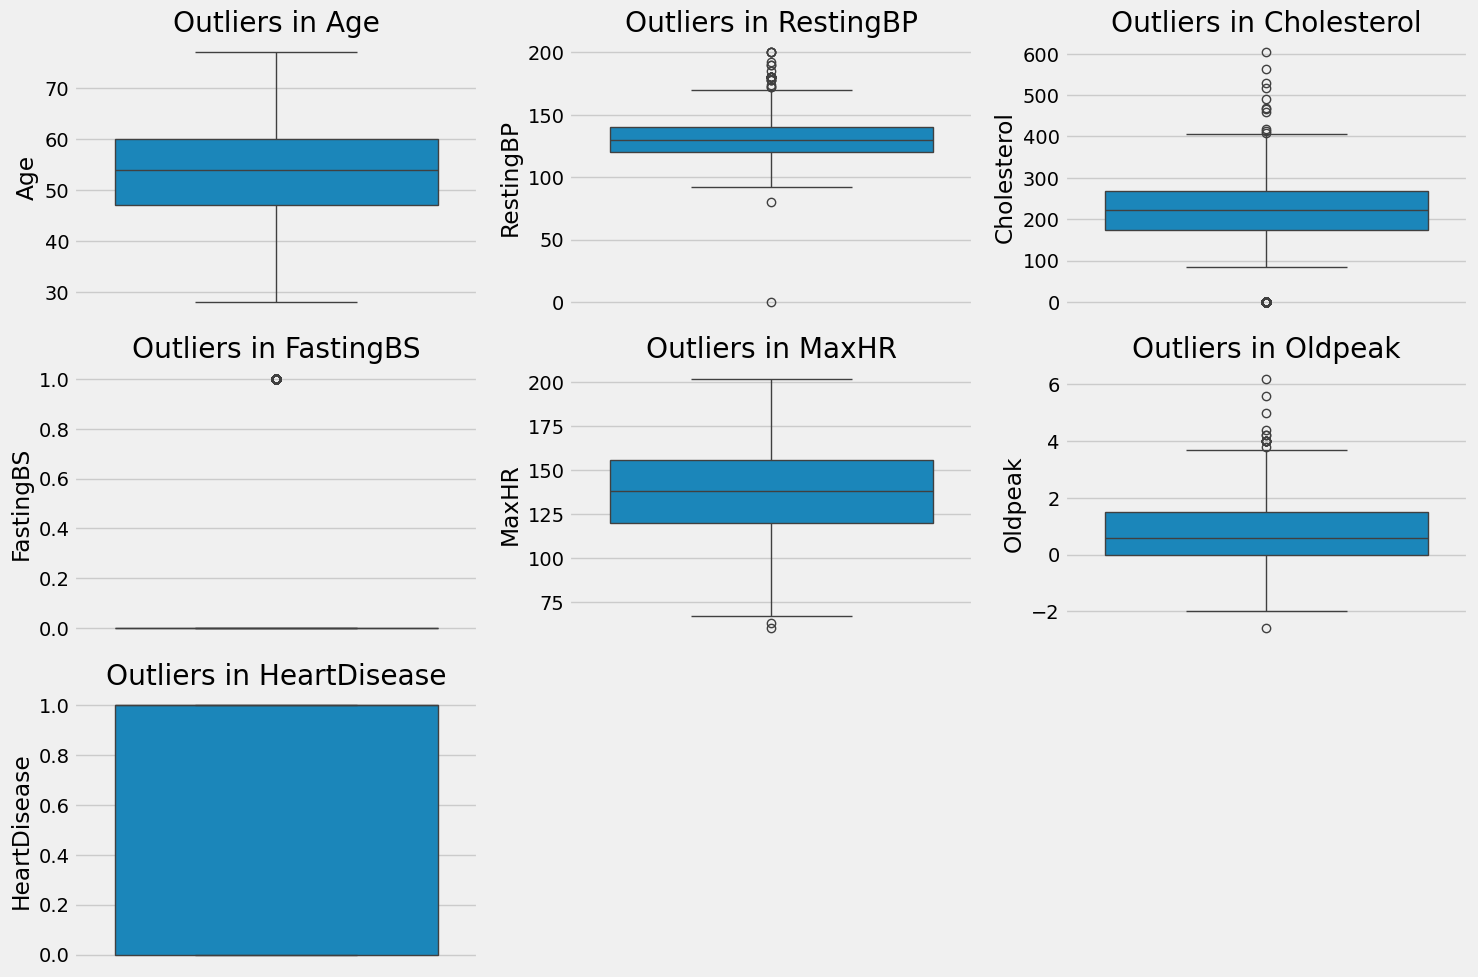

In [15]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

In [16]:
print('The Number of zero values in cholesterol:', df[df['Cholesterol'] <1].count()[0])
print('The mean of cholestrol:', df['Cholesterol'].mean())
print('The median of cholestrol:', df['Cholesterol'].median())

The Number of zero values in cholesterol: 172
The mean of cholestrol: 198.7995642701525
The median of cholestrol: 223.0


In [17]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.50,Flat,1


In [18]:
df = df[df['RestingBP'] != 0]

In [19]:
df['Cholesterol'].replace(0, np.nan, inplace=True)

choMean = df['Cholesterol'].median()

df['Cholesterol'] = df['Cholesterol'].fillna(choMean)

In [20]:
df[df['Oldpeak'] <= 0].shape[0]

381

- According to my research negative values in Oldpeak is not an error
- Oldpeak = 0: No ST segment depression. This is generally normal and indicates that there may not be any significant ischemia during the test.
- Oldpeak > 0: Positive ST segment depression. This suggests the presence of ischemia. The greater the oldpeak value, the more severe the ischemia.

In [21]:
df[df['RestingBP'] <= 1]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [22]:
df['RestingBP'] = df['RestingBP'].replace(0, 132)

In [23]:
print('The Number of zero values in cholesterol:', df[df['Cholesterol'] <1].count()[0])
print('The mean of cholestrol:', df['Cholesterol'].mean())
print('The median of cholestrol:', df['Cholesterol'].median())

The Number of zero values in cholesterol: 0
The mean of cholestrol: 243.21155943293348
The median of cholestrol: 237.0


In [24]:
def detect_outliers_iqr(df, columns):
    for col in columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
        
        outlier_count = outliers.sum() 
        
        if outlier_count > 0:
            outlier_values = df[col][outliers].tolist() 
            print(f"'{col}': Outlier count = {outlier_count}, Outliers = {outlier_values}")
        else:
            print(f"'{col}': Outlier count = 0")

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
detect_outliers_iqr(df, numerical_columns)

'Age': Outlier count = 0
'RestingBP': Outlier count = 27, Outliers = [190, 180, 180, 180, 200, 180, 180, 180, 80, 200, 185, 200, 180, 180, 178, 172, 180, 190, 174, 178, 180, 200, 192, 178, 180, 180, 172]
'Cholesterol': Outlier count = 41, Outliers = [468.0, 518.0, 365.0, 412.0, 529.0, 100.0, 85.0, 392.0, 466.0, 129.0, 393.0, 388.0, 603.0, 404.0, 132.0, 117.0, 355.0, 491.0, 394.0, 126.0, 347.0, 358.0, 100.0, 458.0, 384.0, 349.0, 113.0, 110.0, 123.0, 369.0, 385.0, 564.0, 407.0, 417.0, 126.0, 354.0, 360.0, 409.0, 394.0, 353.0, 131.0]
'FastingBS': Outlier count = 214, Outliers = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

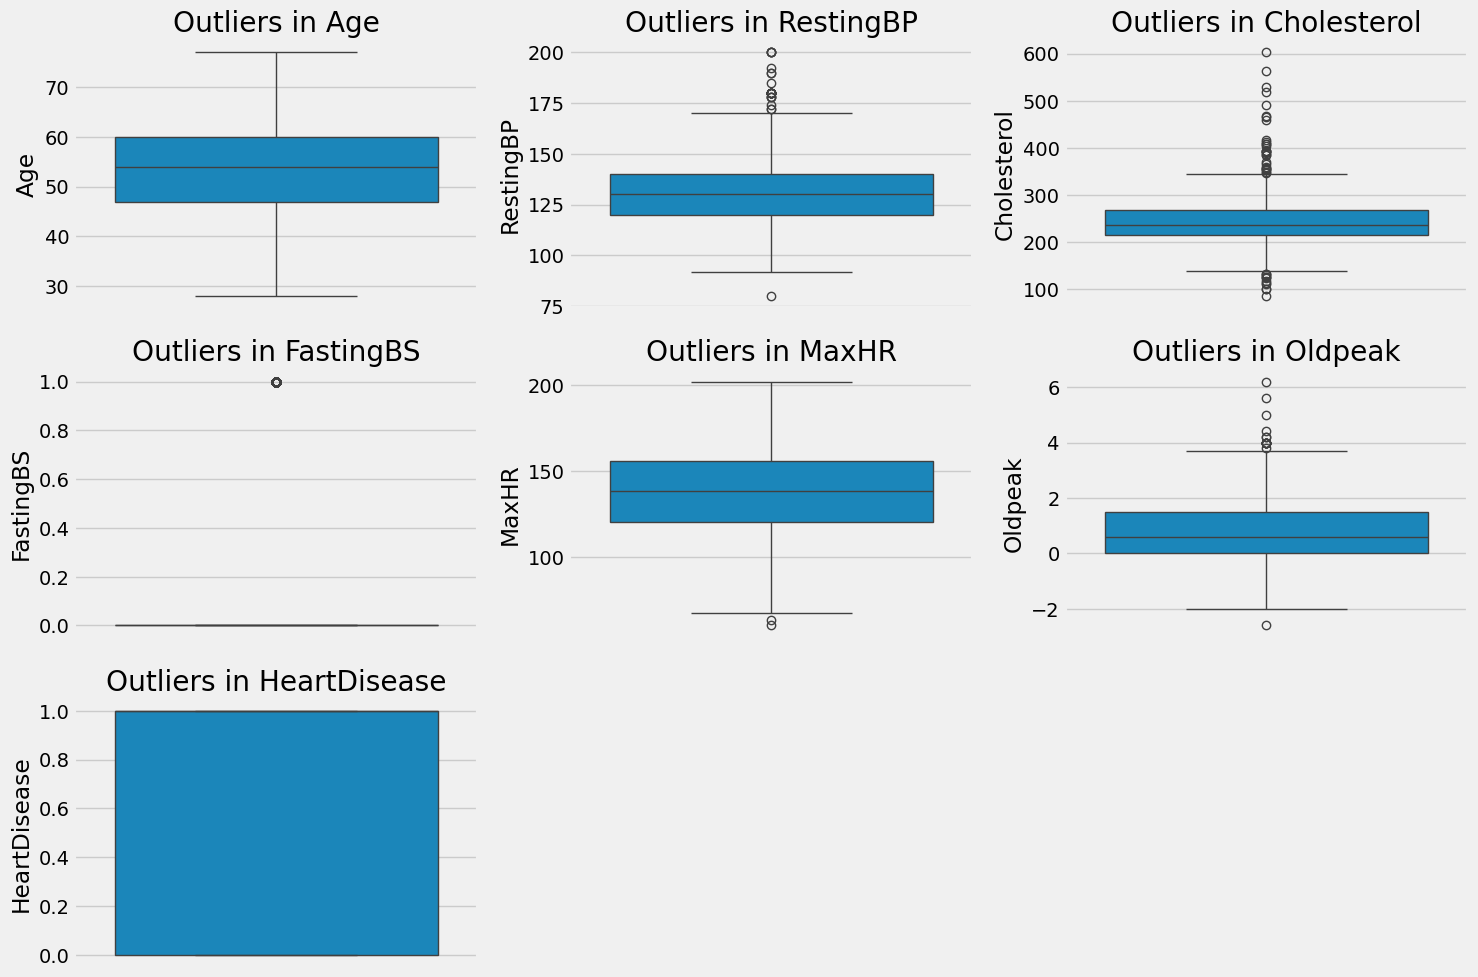

In [25]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

# Basic EDA

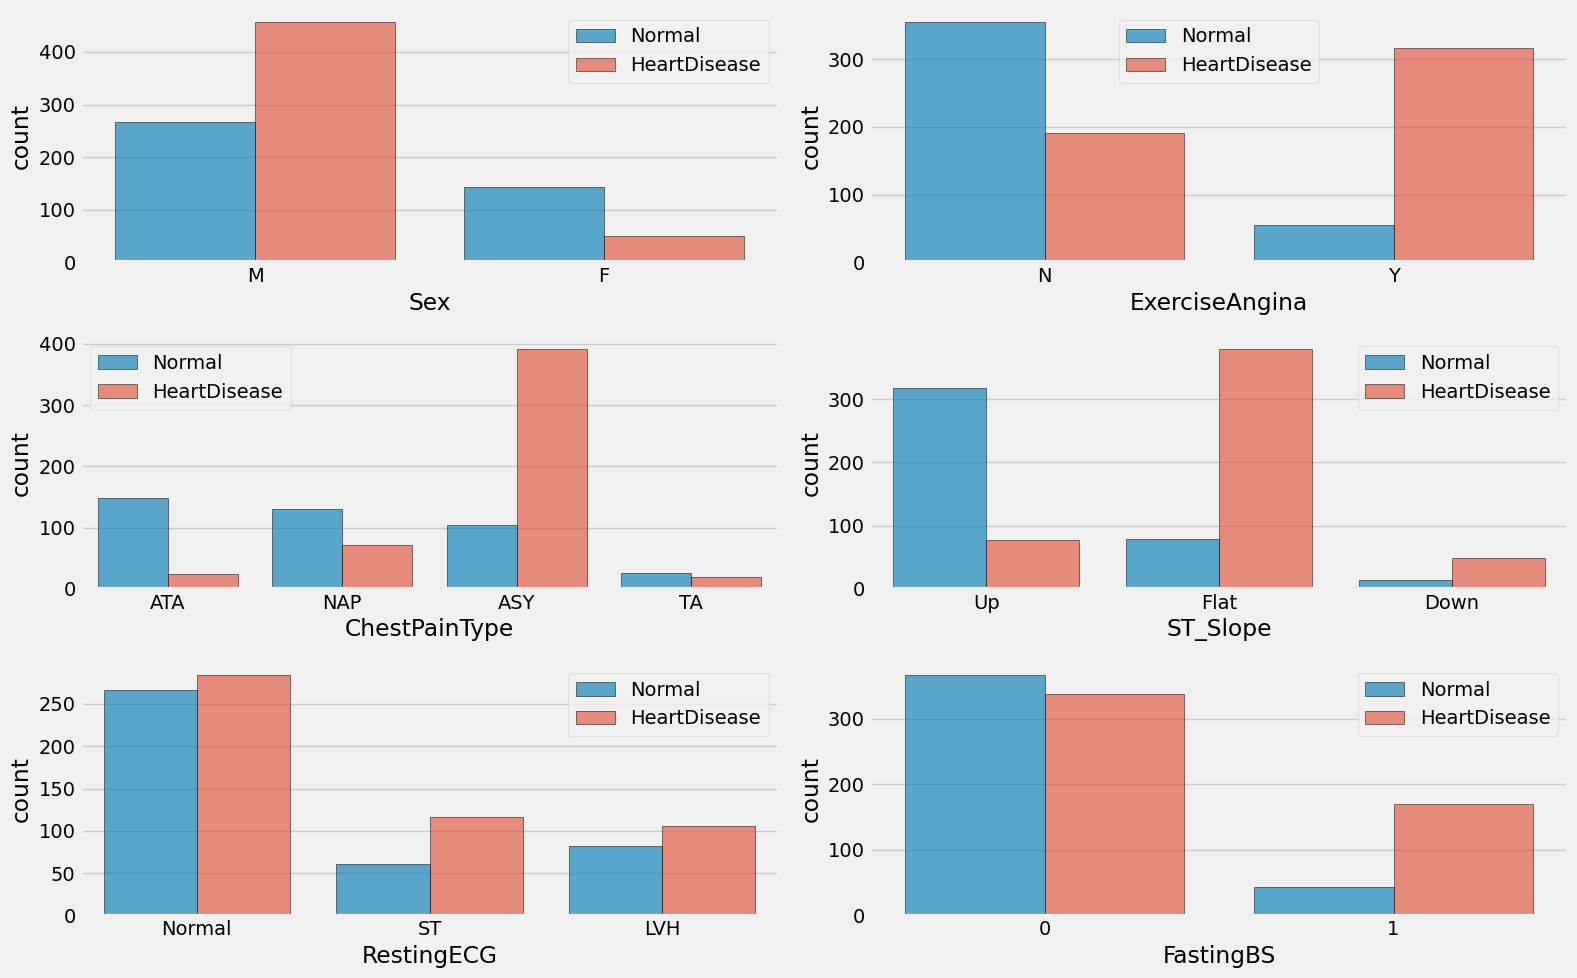

In [26]:
cate_columns = ['Sex', 'ChestPainType','RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

fig, axes = plt.subplots(3, 2, figsize=(16, 10))
axes = axes.flatten(order='f')

for i, col in enumerate(cate_columns):
    sns.countplot(x=df[col], data=df, ax=axes[i], hue = 'HeartDisease', edgecolor='k', alpha =0.7)
    axes[i].legend(labels=['Normal', 'HeartDisease'])

plt.tight_layout()
plt.show()

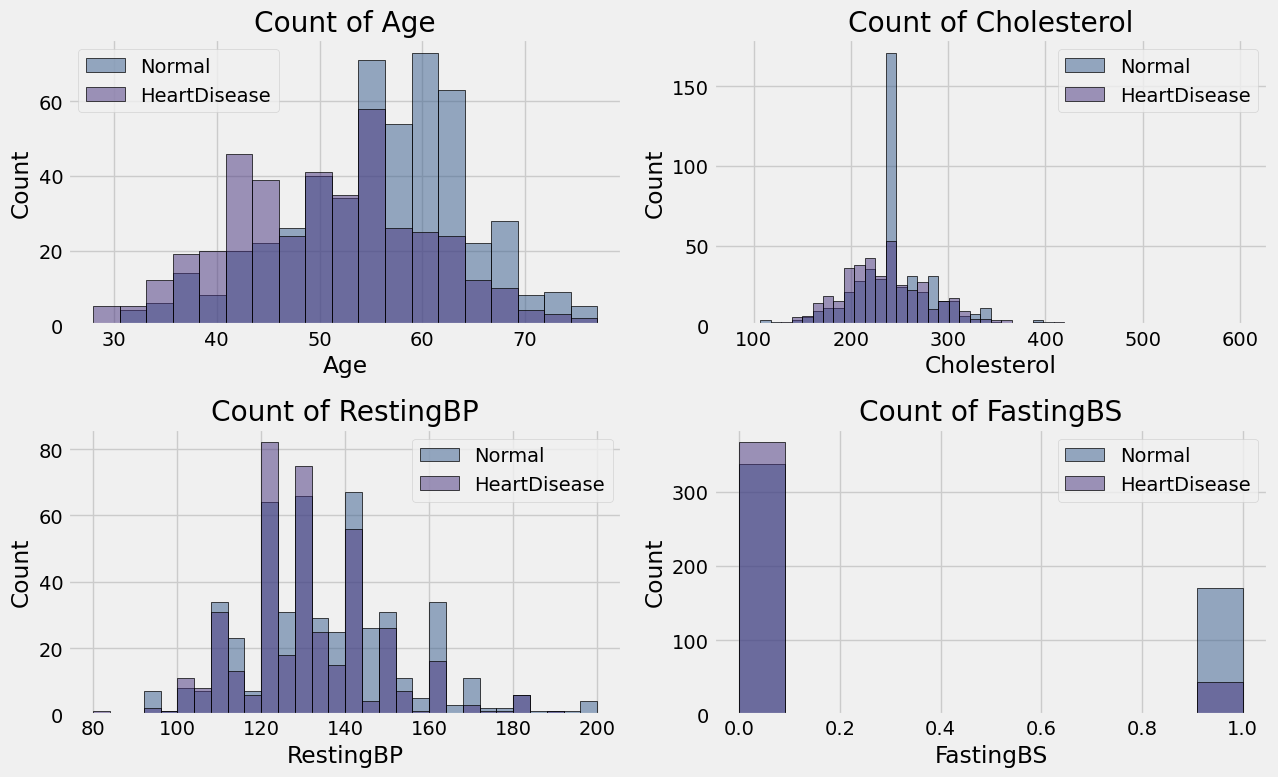

In [27]:
nume_column = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS']

palette = sns.color_palette("viridis") 

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten(order='f')

for i, col in enumerate(nume_column):
    sns.histplot(x=df[col], data=df, ax=axes[i], hue='HeartDisease', edgecolor='k', palette=palette)
    axes[i].set_title(f'Count of {col}')
    axes[i].legend(labels=['Normal', 'HeartDisease'])

plt.tight_layout()
plt.show()

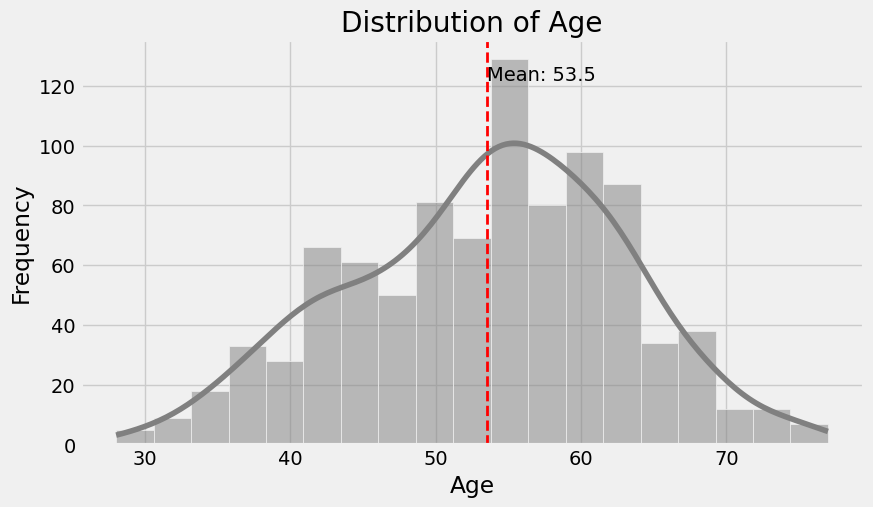

In [28]:
mean_age = df['Age'].mean()

plt.figure(figsize=(9, 5))
sns.histplot(df['Age'], color='gray', kde=True)

plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_age, max(plt.gca().get_ylim())*.9, f'Mean: {mean_age:.1f}', color='k')

plt.title('Distribution of Age')
plt.ylabel('Frequency')
plt.show()

# Analyzation Visulization of Each Columns Deeply

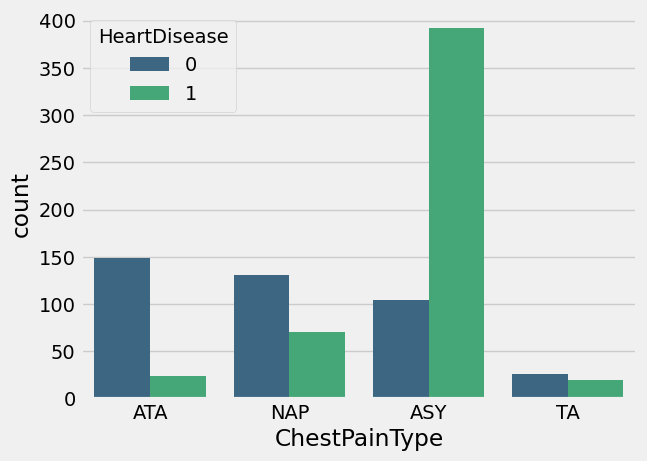

In [29]:
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease', palette='viridis')
plt.show()

In [30]:
df.groupby('ChestPainType')['HeartDisease'].value_counts(normalize=True).unstack()


HeartDisease,0,1
ChestPainType,,
ASY,0.21,0.79
ATA,0.86,0.14
NAP,0.65,0.35
TA,0.57,0.43


In [31]:
avg_age_cpt = df.groupby('ChestPainType')['HeartDisease'].value_counts

print(f'The average Age of {avg_age_cpt}')

The average Age of <bound method SeriesGroupBy.value_counts of <pandas.core.groupby.generic.SeriesGroupBy object at 0x0000022D42C62870>>


- This graph shows that people with ASY (asymptomatic) chest pain are much more likely to have heart disease compared to those in the other three categories combined. Plus, their average age is a bit higher than the others.

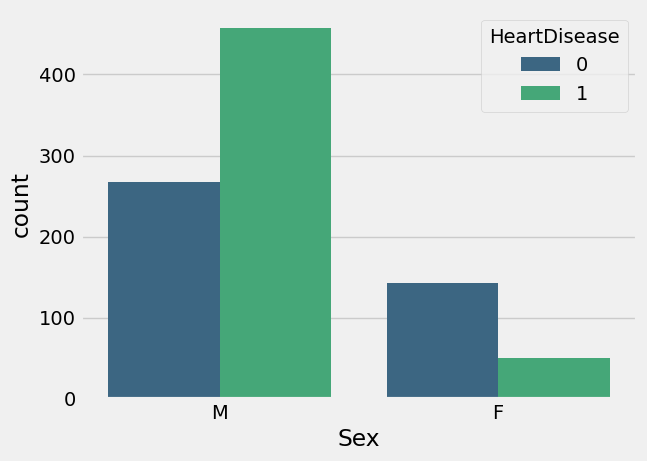

In [32]:
sns.countplot(data=df, x='Sex', hue='HeartDisease', palette='viridis')
plt.show()

In [33]:
yesHRD = df[df['HeartDisease'] == 1]

gender_counts = yesHRD['Sex'].value_counts()
total_count = len(yesHRD)

percentage_male = (gender_counts['M'] / total_count) * 100
percentage_female = (gender_counts['F'] / total_count) * 100

print("Percentage of males with heart disease:", percentage_male)
print("Percentage of females with heart disease:", percentage_female)

Percentage of males with heart disease: 90.13806706114399
Percentage of females with heart disease: 9.861932938856016


- So, according to the graph, people with asymptomatic chest pain (ASY) are way more likely to have heart issues compared to everyone else put together. Also, they tend to be a bit older on average. And get this: a whopping 90% of the Males have heart trouble, while only 9.80% of the Females do. Looks like the guys have it rougher in that department!

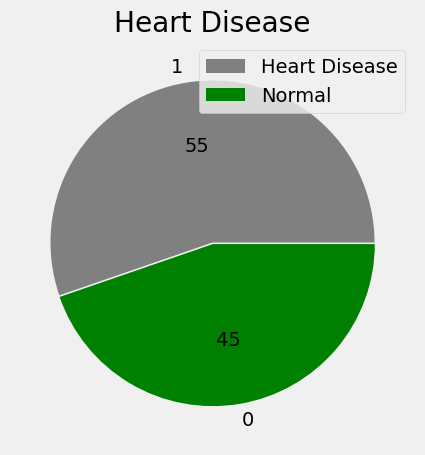

In [34]:
labels=['1','0']
count= df['HeartDisease'].value_counts()
plt.figure(figsize=(6,5))
plt.pie(count,labels=labels,autopct='%.0f', explode=(0,.01), colors=['gray','g'])
plt.legend( ['Heart Disease','Normal'],loc =1)

plt.title('Heart Disease')
plt.show()

In [35]:
No_HRD = df[df['HeartDisease'] == 0]
HRD = df[df['HeartDisease'] == 1]

colss = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

for col in colss:
    No_HRD_Mean = No_HRD.groupby("Sex")[col].mean()
    HRD_Mean = HRD.groupby("Sex")[col].mean()
    
    print(f'Column: {col}')
    print(f'Mean of No Heart Disease by Sex:\n{No_HRD_Mean}\n')
    print(f'Mean of Heart Disease by Sex:\n{HRD_Mean}\n')
    print('-' * 50)

Column: Age
Mean of No Heart Disease by Sex:
Sex
F   51.20
M   50.20
Name: Age, dtype: float64

Mean of Heart Disease by Sex:
Sex
F   56.18
M   55.87
Name: Age, dtype: float64

--------------------------------------------------
Column: RestingBP
Mean of No Heart Disease by Sex:
Sex
F   128.79
M   130.93
Name: RestingBP, dtype: float64

Mean of Heart Disease by Sex:
Sex
F   142.00
M   133.62
Name: RestingBP, dtype: float64

--------------------------------------------------
Column: Cholesterol
Mean of No Heart Disease by Sex:
Sex
F   249.10
M   233.10
Name: Cholesterol, dtype: float64

Mean of Heart Disease by Sex:
Sex
F   270.74
M   244.26
Name: Cholesterol, dtype: float64

--------------------------------------------------
Column: MaxHR
Mean of No Heart Disease by Sex:
Sex
F   149.05
M   147.67
Name: MaxHR, dtype: float64

Mean of Heart Disease by Sex:
Sex
F   137.82
M   126.48
Name: MaxHR, dtype: float64

--------------------------------------------------


- RestingBP: Males tend to have a higher resting blood pressure in no HR disease.
- Cholesterol, Fasting Blood Sugar MaxHR, and Age in both conditions Females generally have higher values in all these categories.

The correlation of Age and HeartDisease: 0.2820117259633895
The correlation of Age and RestingBP: 0.2630844402270465


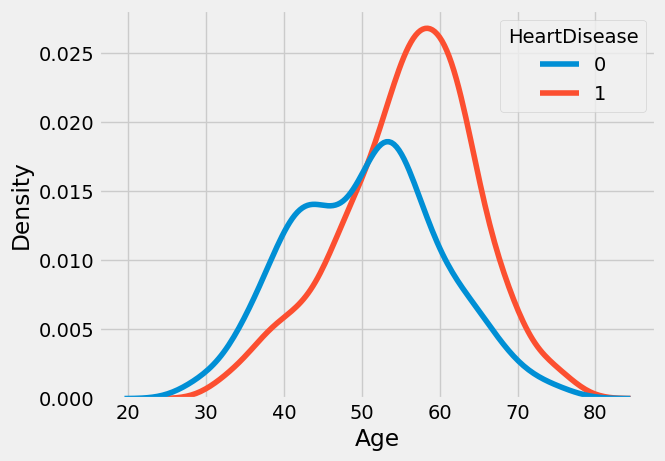

In [36]:
Age_HRcorr = df['Age'].corr(df['HeartDisease'])
print(f'The correlation of Age and HeartDisease: {Age_HRcorr}')

Age_Bpcorr = df['Age'].corr(df['RestingBP'])
print(f'The correlation of Age and RestingBP: {Age_Bpcorr}')

sns.kdeplot(data=df, x='Age', hue='HeartDisease')
plt.show()

The correlation of Age and MaxHR-0.38227954174465617


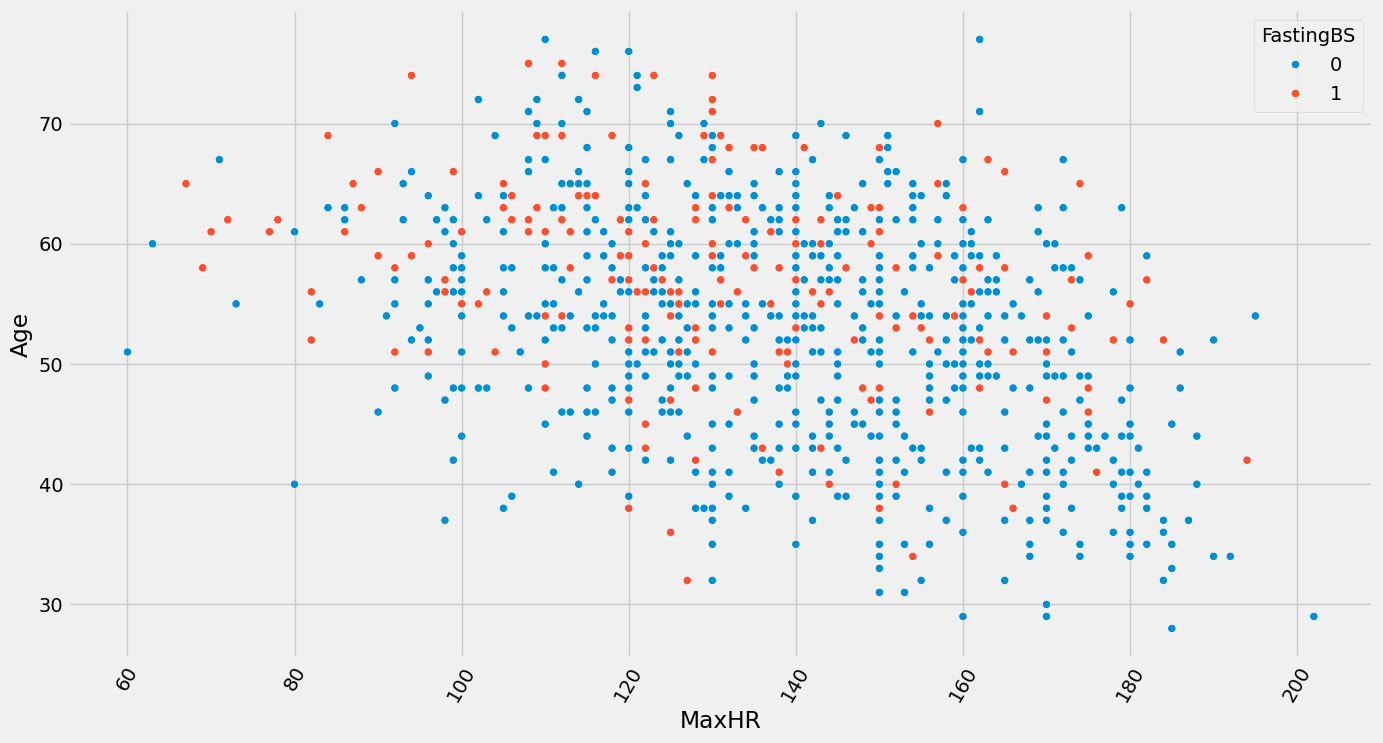

In [37]:
Age_HRcorr = df['Age'].corr(df['MaxHR'])
print(f'The correlation of Age and MaxHR{Age_HRcorr}')

plt.figure(figsize=(15, 8))
sns.scatterplot(x='MaxHR', y='Age', data=df, hue='FastingBS')

plt.xticks(rotation=60)
plt.show()

In [38]:
numerical_columns = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
df[numerical_columns].corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.00,0.26,0.05,-0.38,0.26
RestingBP,0.26,1.00,0.09,-0.11,0.17
Cholesterol,0.05,0.09,1.00,-0.00,0.05
MaxHR,-0.38,-0.11,-0.00,1.00,-0.16
Oldpeak,0.26,0.17,0.05,-0.16,1.00


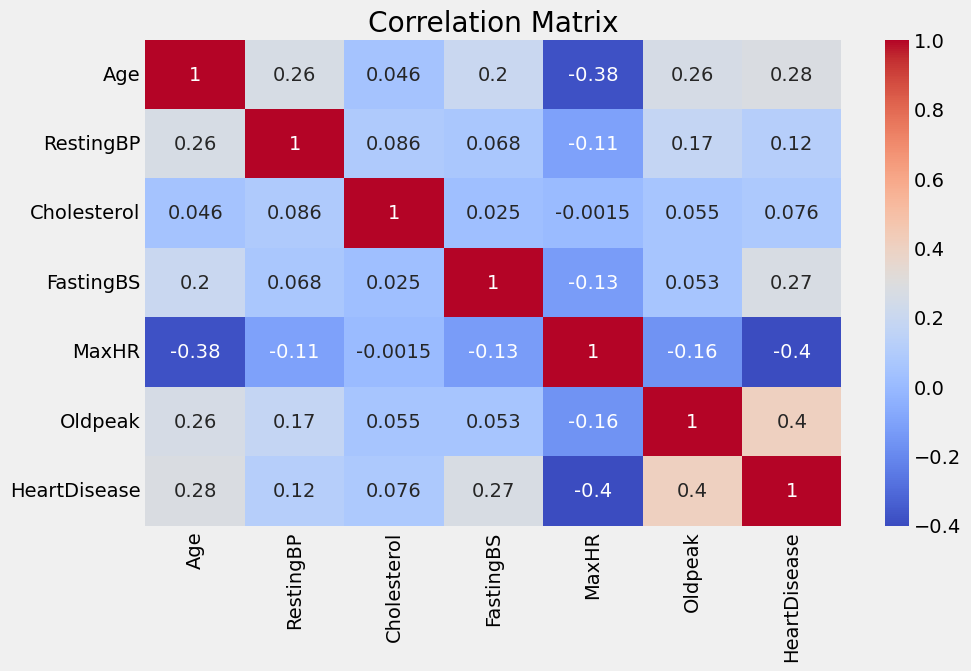

In [39]:
numeric_df = df.select_dtypes(include='number')

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [40]:
pd.crosstab(df.Sex,df.HeartDisease)

HeartDisease,0,1
Sex,,
F,143,50
M,267,457


In [41]:
resting_ecg_hrd = df.groupby('RestingECG')['HeartDisease'].value_counts(normalize=True).unstack()
print(resting_ecg_hrd)

HeartDisease    0    1
RestingECG            
LVH          0.44 0.56
Normal       0.48 0.52
ST           0.34 0.66


<Axes: xlabel='RestingECG', ylabel='count'>

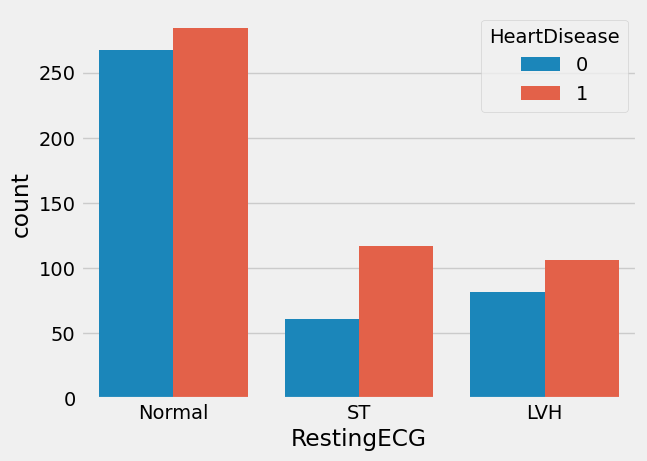

In [42]:
sns.countplot(data= df, x= 'RestingECG', hue='HeartDisease')

- i'm really confused that is normal ecg related to heartdisease or no because there lot's of heartdisease values in normal category 
- anyway normal has the highest count of heart disease patient then ST

<Axes: xlabel='ST_Slope', ylabel='Count'>

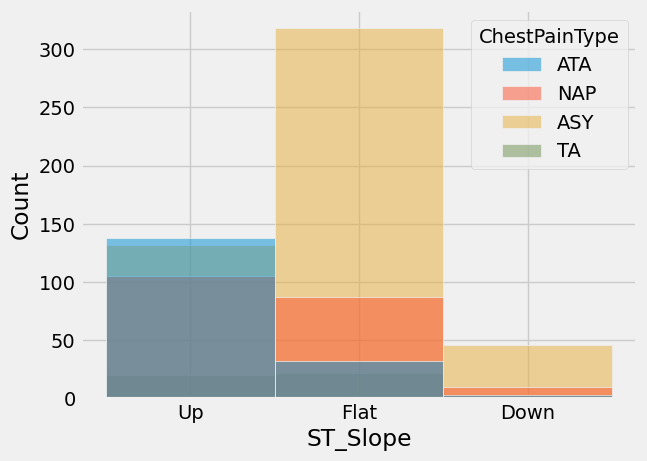

In [43]:
sns.histplot(data= df, x= 'ST_Slope', hue='ChestPainType', common_norm=True, fill=True)

In [44]:
df.groupby('ChestPainType')['HeartDisease'].value_counts(normalize=True).unstack()

HeartDisease,0,1
ChestPainType,,
ASY,0.21,0.79
ATA,0.86,0.14
NAP,0.65,0.35
TA,0.57,0.43


- this Graph shows that when the people are in flat slope mostly they have heart disease and little bit Down
- acoording to my research
- Upsloping: This can sometimes be seen in normal individuals, especially younger people, and might not necessarily indicate a problem. 
- flat: A flat ST segment can indicate ischemia, which is a condition where the heart muscle isn't getting enough blood flow and oxygen, often due to blocked arteries.
- Downsloping: This is often considered a more concerning sign and can indicate significant heart problems, such as severe ischemia or other forms of heart disease.

In [45]:
CPT_mean_cho = df.groupby('ChestPainType')['Cholesterol'].mean().sort_values(ascending=False)
slop_mean_cho = df.groupby('ST_Slope')['Cholesterol'].mean().sort_values(ascending=False)

print("Mean Cholesterol by Chest Pain Type:")
print(CPT_mean_cho)
print("\nMean Cholesterol by ST Slope:")
print(slop_mean_cho)


Mean Cholesterol by Chest Pain Type:
ChestPainType
ASY   246.85
ATA   242.64
NAP   237.13
TA    232.83
Name: Cholesterol, dtype: float64

Mean Cholesterol by ST Slope:
ST_Slope
Flat   247.88
Down   240.46
Up     238.23
Name: Cholesterol, dtype: float64


- the chest pain type asy have the highest avg cholestrol level and st slope falt have the highest avg level of cholestrol according to my analysis those who have these two asy and falt it more higher chance to have heart disease 

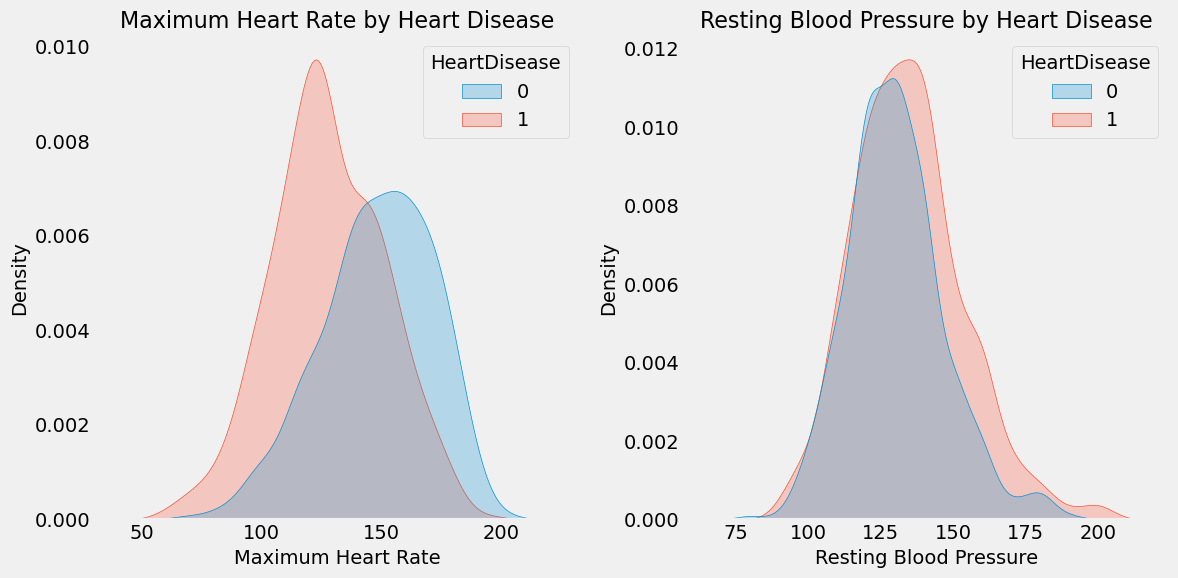

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(data=df, x='MaxHR', hue='HeartDisease', fill=True, ax=axes[0])
axes[0].set_title('Maximum Heart Rate by Heart Disease', fontsize=16)
axes[0].set_xlabel('Maximum Heart Rate', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].grid(visible=None)

sns.kdeplot(data=df, x='RestingBP', hue='HeartDisease', fill=True, ax=axes[1])
axes[1].set_title('Resting Blood Pressure by Heart Disease', fontsize=16)
axes[1].set_xlabel('Resting Blood Pressure', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].grid(visible=None)

plt.tight_layout()
plt.show()

- These two graphs indicate that heart disease patients are more likely to have a lower MaxHR compared to those without the condition. Additionally, RestingBP does not appear to significantly impact the likelihood of having heart disease.

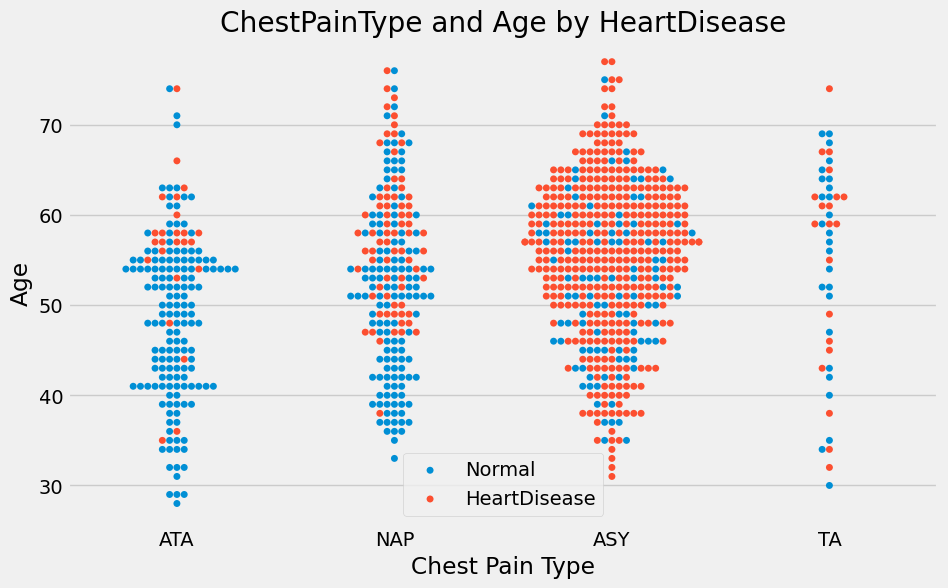

In [47]:
plt.figure(figsize = (10, 6))
sns.swarmplot(x = 'ChestPainType', y = 'Age', data = df, hue='HeartDisease')

plt.title('ChestPainType and Age by HeartDisease')
plt.xlabel('Chest Pain Type')
plt.ylabel('Age')

plt.legend(labels = ['Normal', 'HeartDisease'])
plt.show()

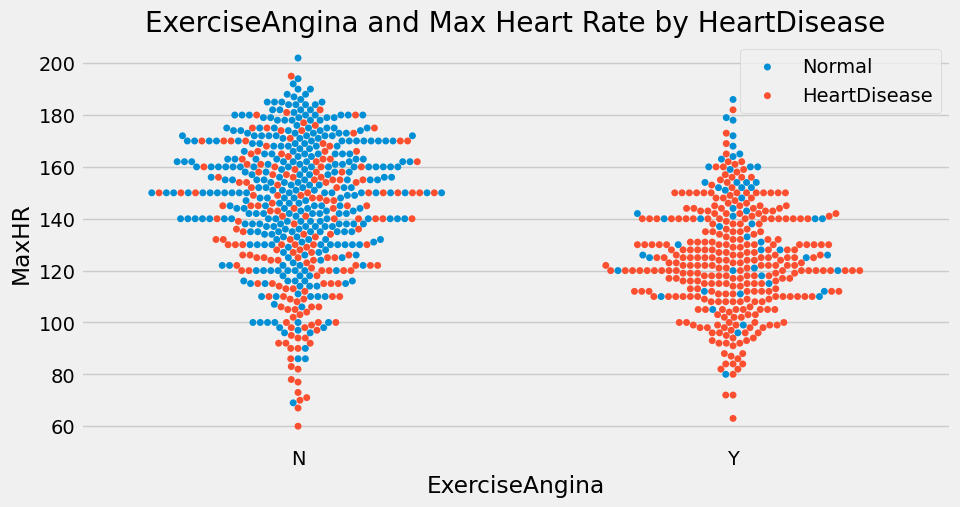

In [48]:
plt.figure(figsize = (10, 5))
sns.swarmplot(x = 'ExerciseAngina', y = 'MaxHR', data = df, hue='HeartDisease')

plt.title('ExerciseAngina and Max Heart Rate by HeartDisease')
plt.legend(labels = ['Normal', 'HeartDisease'])
plt.show()

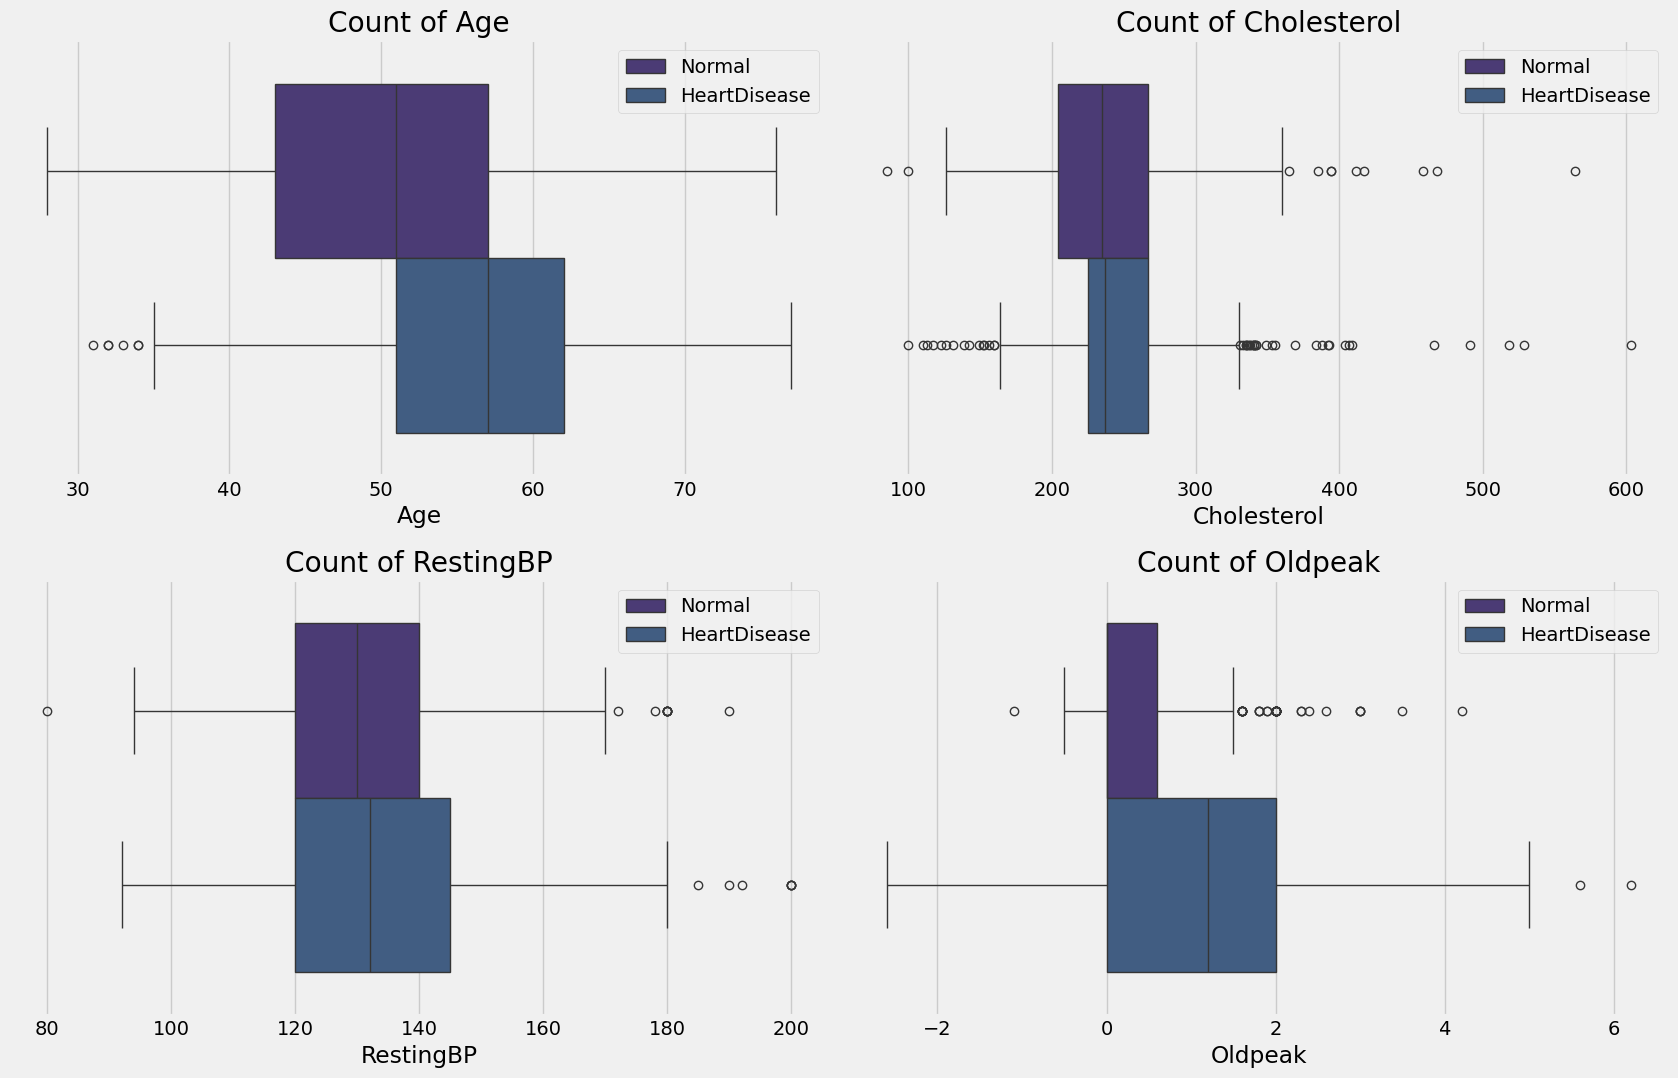

In [49]:
cate_column = ['Age', 'RestingBP', 'Cholesterol', 'Oldpeak']

fig, axes = plt.subplots(2, 2, figsize=(17, 11))

axes = axes.flatten(order='f')

palette = sns.color_palette("viridis")

for i, col in enumerate(cate_column):
    sns.boxplot(x=df[col], data=df, ax=axes[i], palette=palette, hue = 'HeartDisease')#, edgecolor='k')
    axes[i].set_title(f'Count of {col}')
    axes[i].legend(#title='HeartDisease', 
                   labels=['Normal', 'HeartDisease'])

plt.tight_layout()
plt.show()

- there is some outliars in this datasets but i won't remove it now i want to see the score and model performance first

- most of heart disease have asy chest pain and mostly their age is above 50 it seem that mostly the people have heart disease after the age of 50 Percentage of males with heart disease: 90.15748031496062 and Percentage of females with heart disease: 9.84251968503937

- People with heart-related diseases tend to have a lower maximum heart rate compared to those without heart issues, who generally have higher maximum.
and their resting bp is bit higher compare to normal people and also their cholestrol level is bit higher than normal and heart disease patient have flat st slope it also one of the biggest sumptyce and little bit down one as well 
Resting ecg  the type of st it tend have higher chance to have heart disease even the count in the norma ecg is more but also normal people have lots normal esting ecg so and percentage wise st is a bit stronger syptm.
accoring to our analysis when is increasing the maxHR decreasing so it mean maxhR most commly higher in young people 

- The corr between age and heart disease and RestingBP is about 30 percent 

# Model Building:

### Model Pipeline

In [50]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_columns = [col for col in df.columns if col not in categorical_columns and col != 'HeartDisease']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

processed_data = pipeline.fit_transform(df)

### Traing and Testing Models

#### Split Train and Test

In [51]:
X = df.drop(columns='HeartDisease', axis=1)
Y = df['HeartDisease']

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=3)

In [53]:
ojj =[col for col in X_test.columns if X_test[col].dtype == 'object']

for col in ojj:
    print(f"'{col}': {X_test[col].unique()}")


'Sex': ['M' 'F']
'ChestPainType': ['ASY' 'ATA' 'NAP' 'TA']
'RestingECG': ['LVH' 'Normal' 'ST']
'ExerciseAngina': ['N' 'Y']
'ST_Slope': ['Flat' 'Up' 'Down']


In [54]:
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
     }

### Scoring Each Model

In [55]:
Skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        (name, model) ])
    
    cv_scores = cross_val_score(pipeline,X, Y, scoring='accuracy', cv=Skf, n_jobs=None)

    pipe_model = pipeline.fit(X_train, Y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(Y_test, y_pred)

    print(f'The Accuracy score of {name}: {accuracy}')
    print(f'Mean cross-validation score of {name}: {cv_scores.mean()}')
    print("_"*65)

The Accuracy score of RandomForestClassifier: 0.8641304347826086
Mean cross-validation score of RandomForestClassifier: 0.8647778569731528
_________________________________________________________________
The Accuracy score of GradientBoostingClassifier: 0.8641304347826086
Mean cross-validation score of GradientBoostingClassifier: 0.8647956759325256
_________________________________________________________________


#### Now using these Random_state to get more metric score 

In [56]:
last_models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()}
states = [4, 16]

for model_name, model in last_models.items():
    for state in states:
        stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        kf_score = cross_val_score(pipeline, X, Y, scoring='accuracy', cv=stratified_kf, n_jobs=-1)
        
        pipeline.fit(X_train, Y_train)
        
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        print(f'Classification Report for {model_name} (random_state={state}):')
        print(f'Cross-Validation Scores: {np.mean(kf_score)}')
        print(classification_report(Y_test, y_pred))
        
        roc_auc = roc_auc_score(Y_test, y_proba)
        print(f'ROC-AUC for {model_name}: {roc_auc:.2f}')
        print("="*65)

Classification Report for RandomForestClassifier (random_state=4):
Cross-Validation Scores: 0.8669933475885008
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        96
           1       0.82      0.92      0.87        88

    accuracy                           0.86       184
   macro avg       0.87      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184

ROC-AUC for RandomForestClassifier: 0.93
Classification Report for RandomForestClassifier (random_state=16):
Cross-Validation Scores: 0.8669458303635068
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        96
           1       0.81      0.93      0.87        88

    accuracy                           0.86       184
   macro avg       0.87      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184

ROC-AUC for RandomForestClassifier: 0.93
Classification Report for GradientBoostin

### Done and saving the Model

0.8586956521739131


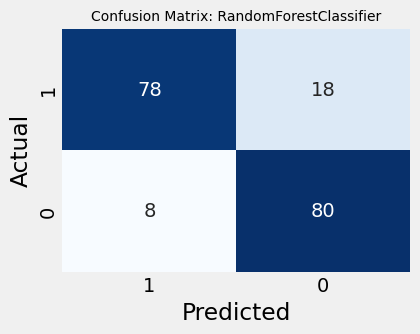

0.8586956521739131


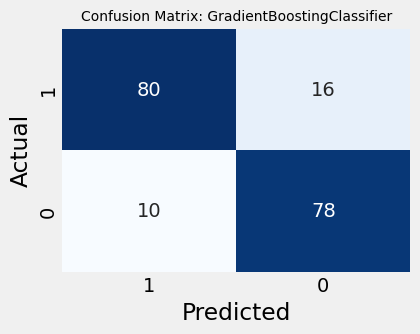

All trained models saved successfully


In [57]:
Final_models = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=105),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150)}

import joblib
trained_models = {}

for name, model in Final_models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])    

    pipeline.fit(X_train, Y_train)  
    trained_models[name] = pipeline  

    Y_pred = pipeline.predict(X_test)
    matrix = confusion_matrix(Y_test, Y_pred)
    accu = accuracy_score(Y_test, Y_pred)

    plt.figure(figsize=(4, 3))
    print(accu)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {name}', size=10)
    plt.show()

joblib.dump(trained_models, 'final_models.pkl')
print("All trained models saved successfully")


In [58]:
import pickle

with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)

print("DataFrame saved successfully")

DataFrame saved successfully
